In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

#pip3 install  scikit-plot
import scikitplot as skplt


%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]

1. Read data frame and rename columns

In [3]:
df = pd.read_csv("Wine.txt", sep='\t')
df.columns = ['i1', 'i2', 'i3','i4','i5','i6','i7','i8','i9','i10','i11','i12','i13','d']

2. Look at first rows to check dataframe is loaded

In [4]:
df.head()

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,d
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


3. Check we have no NaN values in dataframe and check column types are not "objects"

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
i1     178 non-null float64
i2     178 non-null float64
i3     178 non-null float64
i4     178 non-null float64
i5     178 non-null int64
i6     178 non-null float64
i7     178 non-null float64
i8     178 non-null float64
i9     178 non-null float64
i10    178 non-null float64
i11    178 non-null float64
i12    178 non-null float64
i13    178 non-null int64
d      178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


4. Split into train set and test set

In [6]:
np.random.seed(42)
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(df, 0.2)

print("train set shape:{}\n test set shape:{}".format(train_set.shape, test_set.shape))

train set shape:(143, 14)
 test set shape:(35, 14)


5. Copy train set to make sure we don't mutate it by chance

In [7]:
wines = train_set.copy()

6. Check correlations between features visually

/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


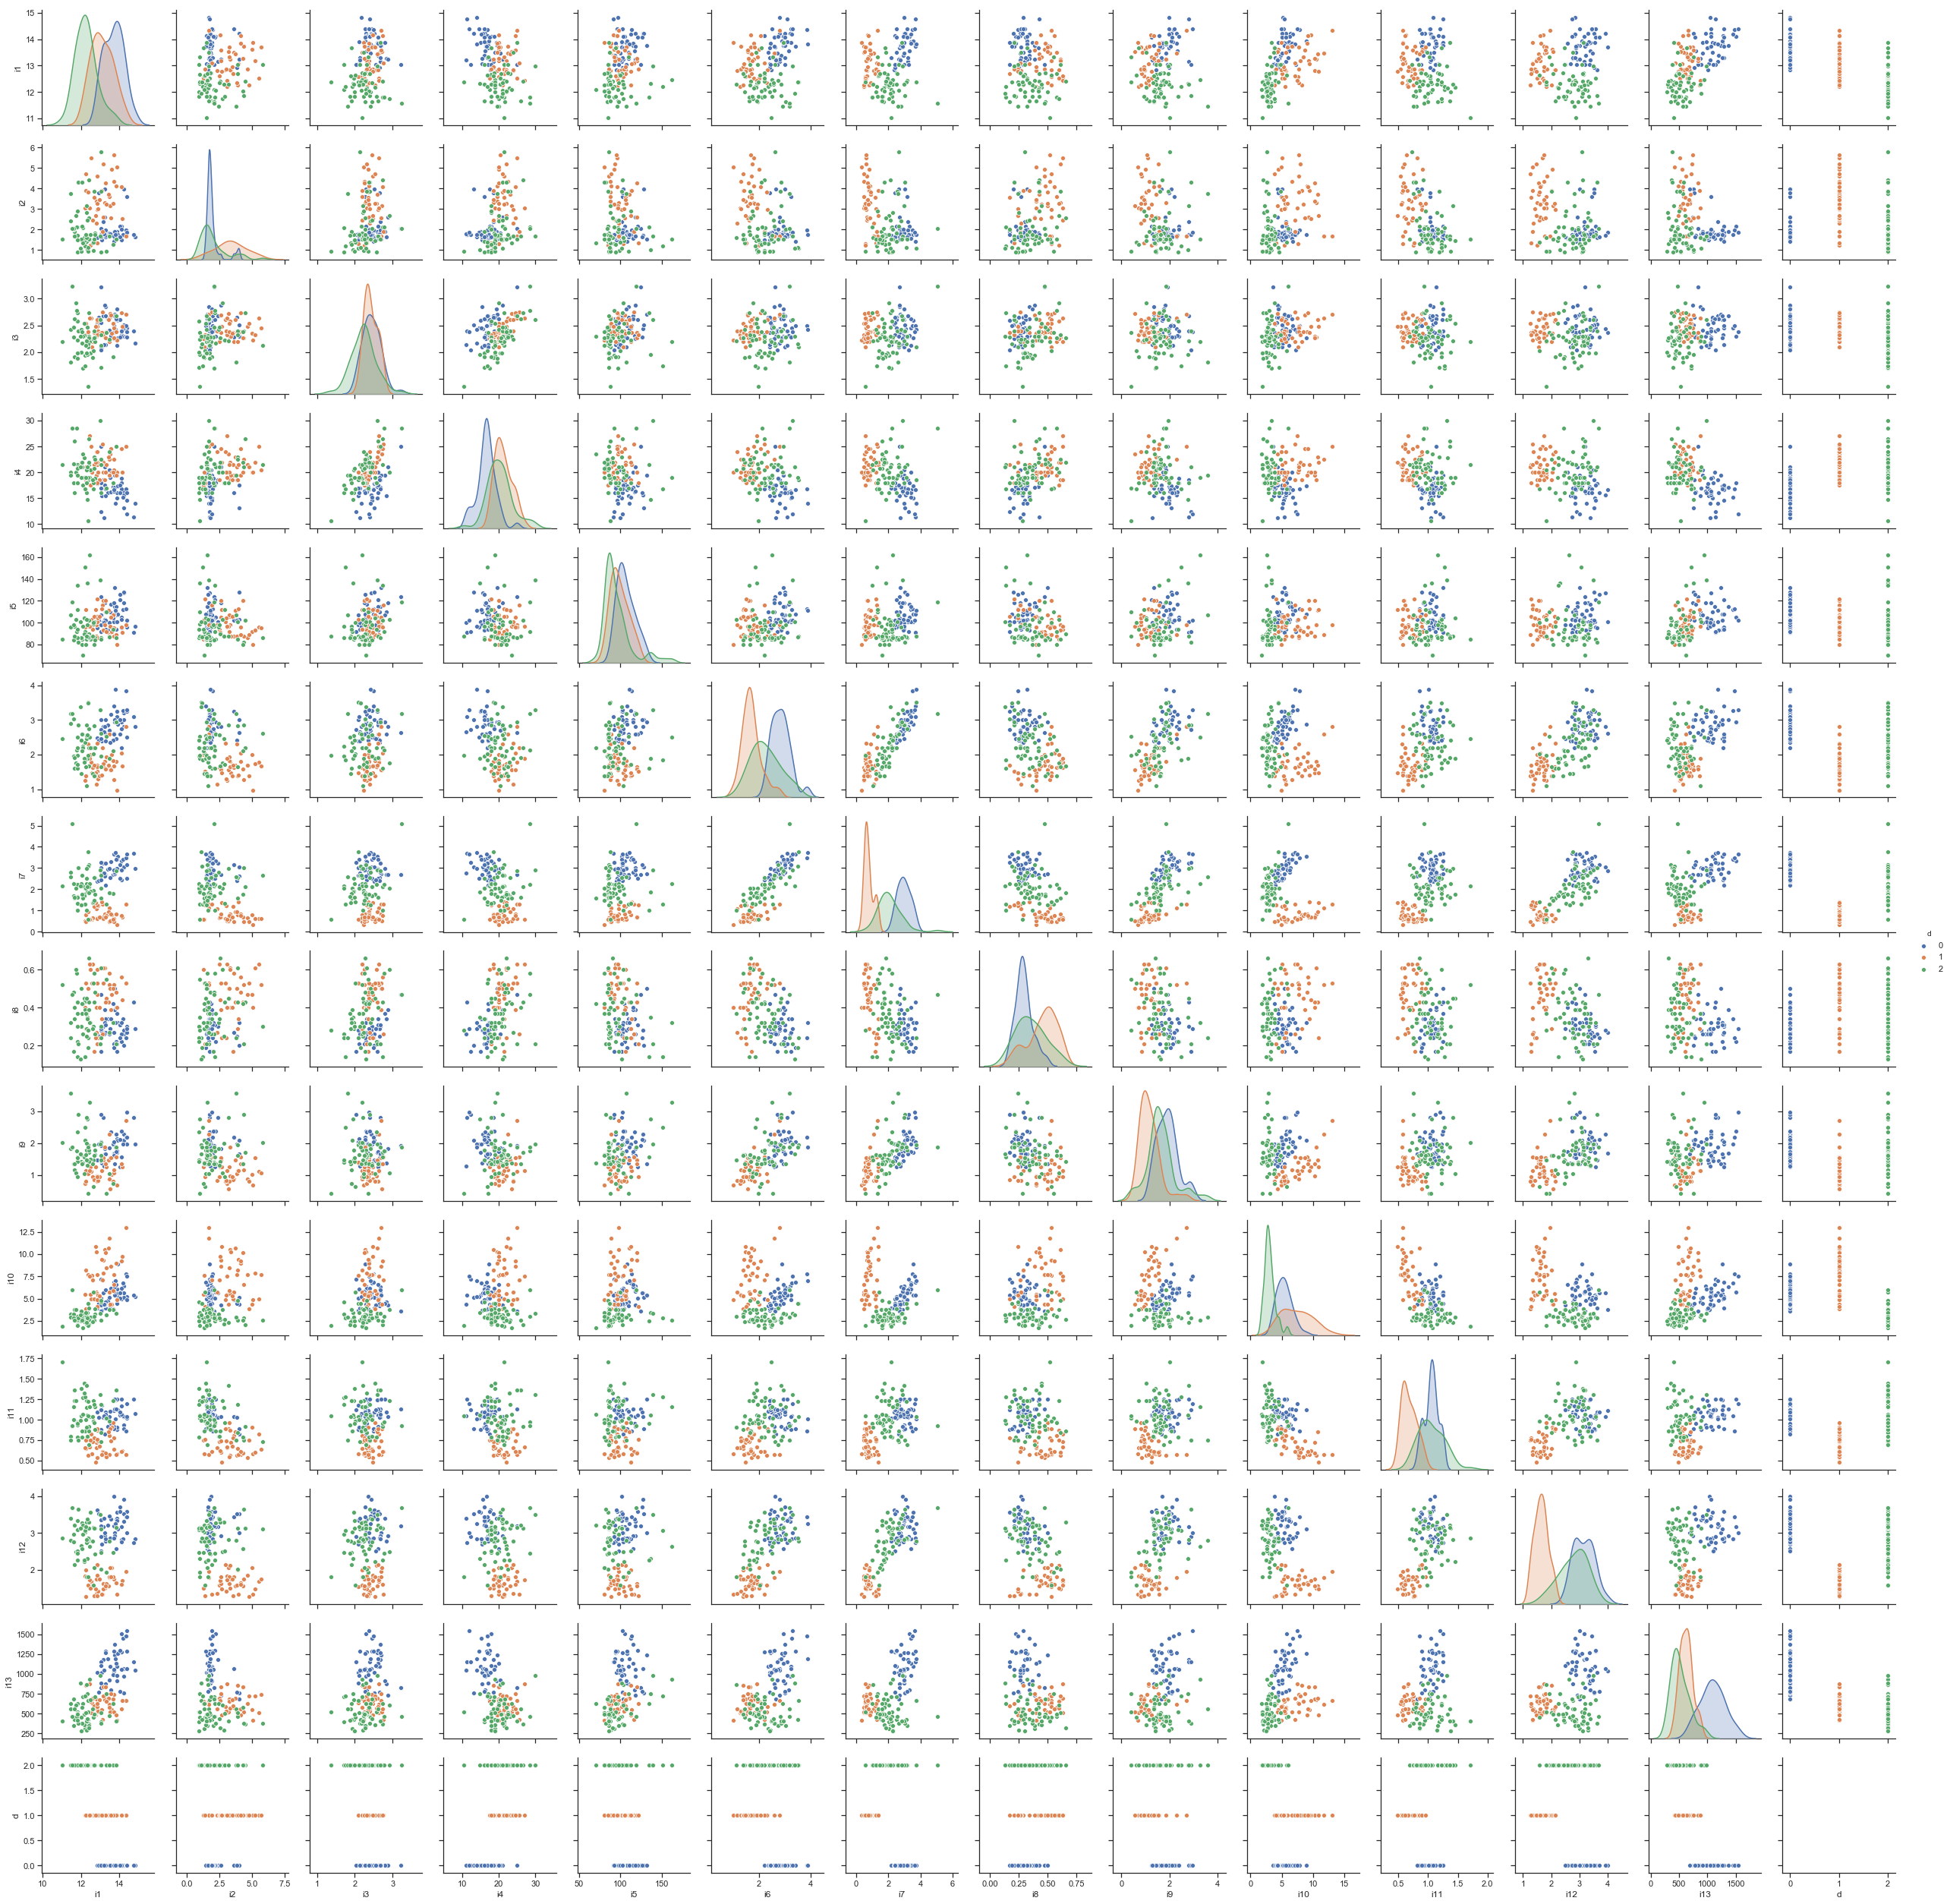

In [15]:
sns.set(style="ticks")
g = sns.pairplot(wines, hue='d')

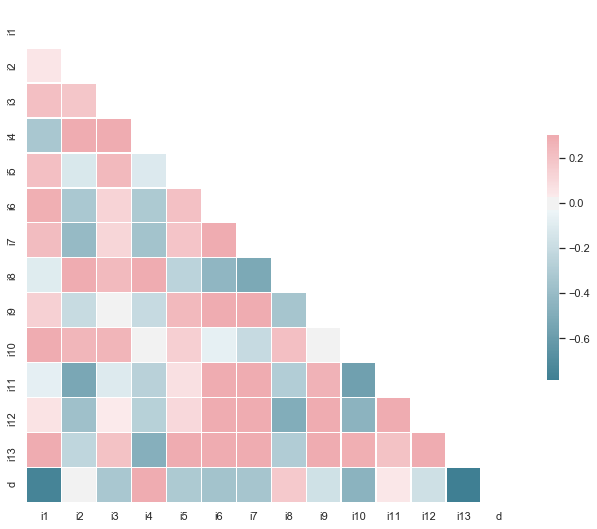

In [10]:
sns.set(style="white")
corr = wines.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

7. Draw feature  histograms. Why???

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ca9ae48>,
      dtype=object)

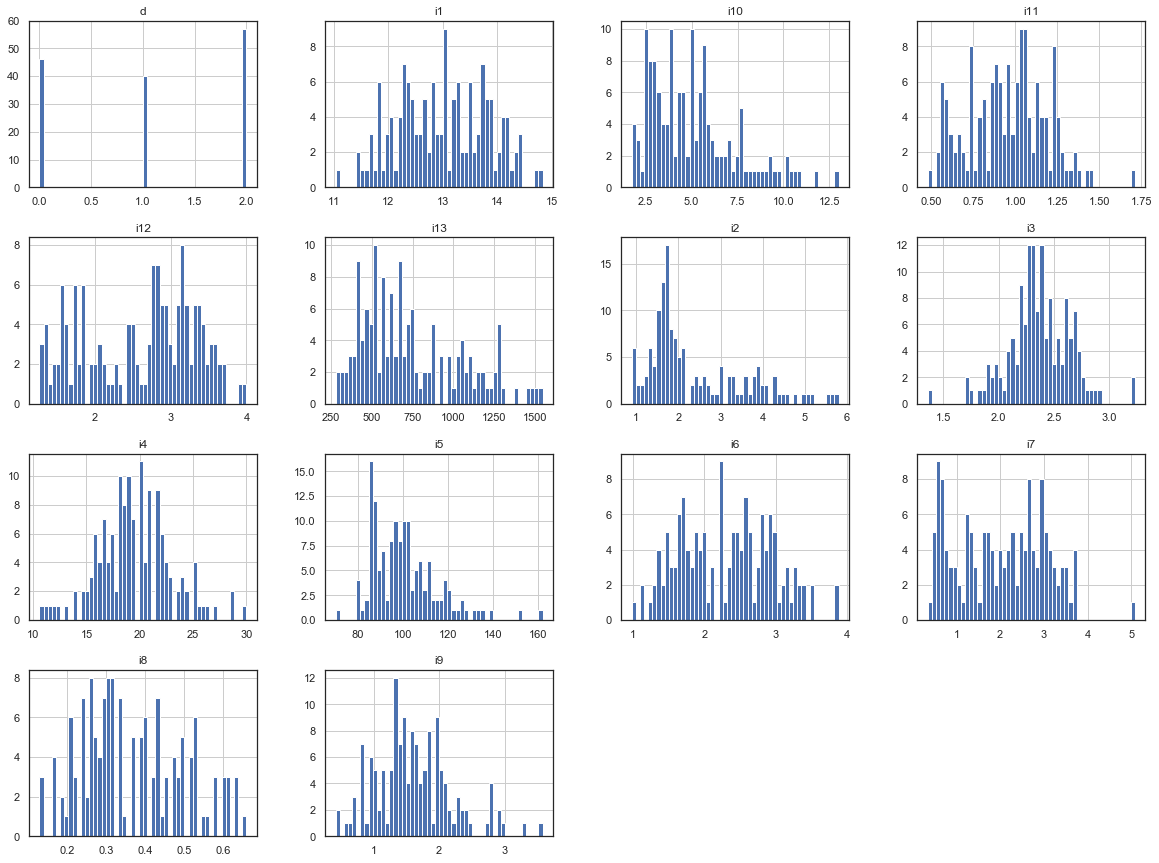

In [19]:
wines.hist(bins=50, figsize=(20,15)) 
plt.show()

8. Check visually whether correlated features really separate

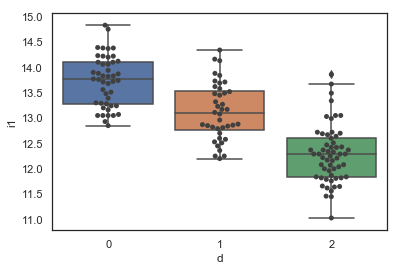

In [20]:
ax = sns.boxplot(x="d", y="i1", data=wines)
ax = sns.swarmplot(x="d", y="i1", data=wines, color=".25")

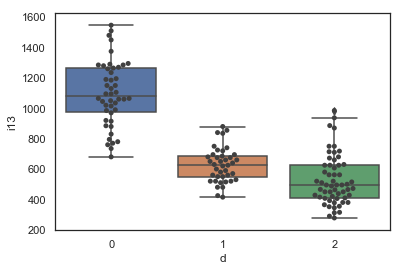

In [21]:
ax = sns.boxplot(x="d", y="i13", data=wines)
ax = sns.swarmplot(x="d", y="i13", data=wines, color=".25")

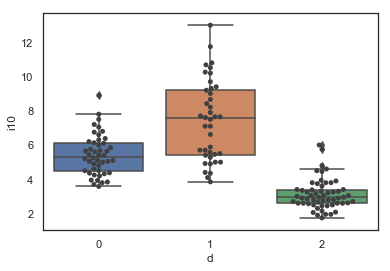

In [22]:
ax = sns.boxplot(x="d", y="i10", data=wines)
ax = sns.swarmplot(x="d", y="i10", data=wines, color=".25")

9. Ok, so  we use i1, i13 for classification

10. Prepare predictor and label frames

In [27]:
X=wines
y=wines[['d']]

11. We will need customer transformer for dropping non-relevant features.

In [28]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class ColumnSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

12. Construct pipeline using dropper and standard scaler transformers. 
We need scaling as many classifiers allow 0..1 scale only for features

In [30]:
pipeline = Pipeline([
            ('dropper', ColumnSelector(['i1','i13'])),
            ('std_scaler', StandardScaler()),
        ])
X_tr = pipeline.fit_transform(X)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(X_tr, y)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


13. Pre-check whether first 5 rows of training set were classified correctly

In [33]:
some_data = wines.iloc[:5]
some_data

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,d
42,13.88,1.89,2.59,15.0,101,3.25,3.56,0.17,1.70,5.43,0.88,3.56,1095,0
158,14.34,1.68,2.70,25.0,98,2.80,1.31,0.53,2.70,13.00,0.57,1.96,660,1
137,12.53,5.51,2.64,25.0,96,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515,1
98,12.37,1.07,2.10,18.5,88,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660,2
159,13.48,1.67,2.64,22.5,89,2.60,1.10,0.52,2.29,11.75,0.57,1.78,620,1


In [37]:
some_labels = y.iloc[:5]
print(some_labels)

     d
42   0
158  1
137  1
98   2
159  1


In [38]:
some_data_prepared = pipeline.transform(some_data)
print("Predictions:", clf.predict(some_data_prepared))

Predictions: [0 1 2 1 1]


/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


14. Verify classifier accuracy

/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


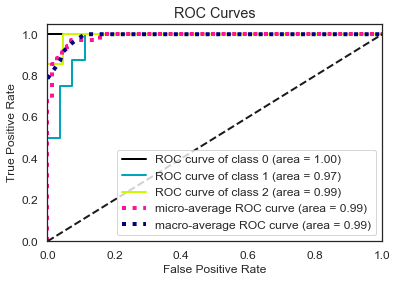

In [39]:
y_score = clf.decision_function(pipeline.transform(test_set))

skplt.metrics.plot_roc_curve(test_set['d'], y_score)
plt.show()